In [59]:
import os
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
# Utah
state_ab = "ut"

## Data
1. Download all the data in directory "ut_data"
2. Extract them all

In [62]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
precinct16_data = "./{}{}_mggg/UT_precincts.shp".format(data_folder, state_ab)
cd_data = "./{}{}_cong_2021/ut_cong_2021.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/ut_sldu_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_2021/ut_sldl_2021.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [63]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [64]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [65]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [66]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [67]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [68]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [69]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [70]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

Gaps to simplify:  88%|████████▊ | 9150/10344 [5:41:32<44:34,  2.24s/it]


In [71]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [72]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [73]:
maup.doctor(population_df)

100%|██████████| 71207/71207 [00:36<00:00, 1965.66it/s]


True

In [74]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
               'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
               'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [75]:
population_df.rename(columns=rename_dict, inplace = True)

In [76]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['NH_WHITE'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['NH_BLACK'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['NH_AMIN'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['NH_ASIAN'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['NH_NHPI'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['NH_OTHER'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['NH_2MORE'], 1)

Make sure that the County shapefile is clean:

In [77]:
maup.doctor(county_df)

100%|██████████| 29/29 [00:00<00:00, 165.14it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [78]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 2424/2424 [00:02<00:00, 1064.33it/s]


There are 1880 overlaps.
There are 9442 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 21637/21637 [00:13<00:00, 1660.80it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 9450it [8:59:19,  3.42s/it]                               
100%|██████████| 2424/2424 [00:02<00:00, 908.70it/s] 


In [79]:
vest20.columns

Index(['CountyID', 'vistapre', 'resultspre', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREIPIE', 'G20PREIWES',
       'G20PREIMCH', 'G20PREILAR', 'G20PREOWRI', 'G20GOVRCOX', 'G20GOVDPET',
       'G20GOVLCOT', 'G20GOVADUE', 'G20GOVOWRI', 'G20ATGRREY', 'G20ATGDSKO',
       'G20ATGLBAU', 'G20AUDRDOU', 'G20AUDCOST', 'G20AUDUFAB', 'G20TRERDAM',
       'G20TRELSPE', 'G20TRECPRO', 'geometry'],
      dtype='object')

In [80]:
start_col = 3
vest_base_data = vest20
year = '20'


In [ ]:
vest_base = add_vest_base(vest20, start_col, year, county = county_df, snap_precision = 8)

100%|██████████| 29/29 [00:00<00:00, 142.06it/s]


Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.


100%|██████████| 29/29 [00:00<00:00, 45.56it/s]


Identifying overlaps...


100%|██████████| 22866/22866 [00:22<00:00, 1011.97it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 23:  13%|█▎        | 305/2357 [00:04<00:53, 38.62it/s]

Let's look at the border lengths.  If there's a clear reasonable cutoff for switching rook adjacencies to queen, we use that.  Otherwise, we can use 30.5 m (which is approximately 100 ft).  This is not a magic number, just a reasonable one.


In [ ]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:2000])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

It's not clear what the cutoff should be here; let's use 30.5.


In [ ]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 2641/2641 [00:00<00:00, 3116.53it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|██████████| 2424/2424 [00:02<00:00, 1108.78it/s]


In [ ]:
maup.doctor(vest_base)

100%|██████████| 2424/2424 [00:02<00:00, 1108.72it/s]


True

### If it is true for maup doctor, we will use it as the base vest data.


In [31]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 2424/2424 [00:11<00:00, 204.92it/s]


In [32]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [33]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [34]:
election_df = gpd.GeoDataFrame(vest_base)

In [35]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID', 'GOV20D',
       'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O', 'TRE20R',
       'geometry', 'resultspre', 'vistapre', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [ ]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [33]:
# vest18 = gpd.read_file(vest18_data)

In [ ]:
# list(vest18.columns)

In [ ]:
# # check the result here
# start_col = 3
# election_df = add_vest(vest18, election_df, '18', population_df, start_col, snap_precision = 8)

In [ ]:
# vest16 = gpd.read_file(vest16_data)

In [37]:
# list(vest16.columns)

['CountyID',
 'PrecinctID',
 'county',
 'precinct',
 'G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PREISTE',
 'G16PREIMCM',
 'G16PREOOTH',
 'G16USSRLEE',
 'G16USSDSNO',
 'G16USSAFON',
 'G16USSIBAR',
 'G16GOVRHER',
 'G16GOVDWEI',
 'G16GOVLKAM',
 'G16GOVASCH',
 'G16ATGRREY',
 'G16ATGDHAR',
 'G16ATGLMCC',
 'G16ATGAISB',
 'G16AUDRDOU',
 'G16AUDDMIT',
 'G16AUDAGRE',
 'G16TRERDAM',
 'G16TREDHAN',
 'G16TRECPRO',
 'geometry']

In [ ]:
# # check the result here
# start_col = 4
# election_df = add_vest(vest16, election_df, '16', population_df, start_col)

In [41]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID', 'GOV20D',
       'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O', 'TRE20R',
       'geometry', 'resultspre', 'vistapre', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

##  Add the district data

In [42]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [ ]:
cong_df.head()

,DISTRICTNO,TAPERSONS,VAPERSONS,geometry
0,1.0,817904.0,584771.0,"POLYGON ((374537.211 4548366.993, 373922.275 4..."
1,2.0,817904.0,594250.0,"POLYGON ((230239.697 4158164.412, 230243.313 4..."
2,3.0,817904.0,592597.0,"POLYGON ((422481.576 4479126.873, 422483.194 4..."
3,4.0,817904.0,552433.0,"POLYGON ((383722.782 4379271.884, 383883.006 4..."


In [44]:
set(cong_df['DISTRICTNO'])

{1.0, 2.0, 3.0, 4.0}

In [ ]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICTNO")

100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


In [46]:
send.head()

,DISTRICTNO,TAPERSONS,VAPERSONS,geometry
0,1.0,110855.0,73770.0,"POLYGON ((242780.546 4508799.493, 242781.181 4..."
1,2.0,111491.0,80463.0,"POLYGON ((403427.503 4650009.510, 403447.485 4..."
2,3.0,112971.0,81369.0,"POLYGON ((414912.046 4574915.675, 414992.884 4..."
3,4.0,113791.0,78686.0,"POLYGON ((374546.575 4548378.937, 375420.477 4..."
4,5.0,112790.0,82763.0,"POLYGON ((412766.585 4552384.407, 412888.309 4..."


In [47]:
len(set(send['DISTRICTNO']))

29

In [ ]:
hdist.head()

,DISTRICTNO,TAPERSONS,VAPERSONS,geometry
0,1.0,43137.0,29337.0,"POLYGON ((244150.898 4543388.757, 244190.257 4..."
1,2.0,43892.0,29836.0,"POLYGON ((413372.548 4632267.976, 413387.693 4..."
2,3.0,43860.0,34965.0,"POLYGON ((425028.946 4622343.852, 425049.196 4..."
3,4.0,43697.0,31102.0,"POLYGON ((428054.244 4554352.045, 428054.988 4..."
4,5.0,43323.0,27924.0,"POLYGON ((412478.969 4617021.002, 412493.041 4..."


In [49]:
len(set(hdist['DISTRICTNO']))

75

In [ ]:
election_df = add_district(send, "SEND", election_df, "DISTRICTNO")

100%|██████████| 29/29 [00:01<00:00, 25.53it/s]


In [ ]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICTNO")

100%|██████████| 75/75 [00:01<00:00, 64.02it/s]


In [52]:
list(election_df.columns)

['ATG20D',
 'ATG20O',
 'ATG20R',
 'AUD20O',
 'AUD20R',
 'CountyID',
 'GOV20D',
 'GOV20O',
 'GOV20R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'TRE20O',
 'TRE20R',
 'geometry',
 'resultspre',
 'vistapre',
 'TOTPOP',
 'HISP',
 'NH_WHITE',
 'NH_BLACK',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_NHPI',
 'NH_OTHER',
 'NH_2MORE',
 'H_WHITE',
 'H_BLACK',
 'H_AMIN',
 'H_ASIAN',
 'H_NHPI',
 'H_OTHER',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'CD',
 'SEND',
 'HDIST']

### Put the base precinct year after the precinct information column

In [53]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'CountyID':'CountyID'+year,
        'vistapre':'vistapre'+year,
        'resultspre':'resultspre'+year}
election_df.rename(columns=base_columns, inplace = True)

In [54]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID20',
       'GOV20D', 'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O',
       'TRE20R', 'geometry', 'resultspre20', 'vistapre20', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [55]:
# reorder the columns
fixed_columns = [
    'CountyID'+year,
    'vistapre'+year,
    'resultspre'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [56]:
os.makedirs("./{}".format(state_ab), exist_ok=True)
election_df.to_file("./{}/{}.shp".format(state_ab, state_ab))
election_df.to_file('./{}/{}.geojson'.format(state_ab, state_ab), driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file("./{}/{}.shp".format(state_ab, state_ab), ignore_errors=True)
graph.to_json("./{}/{}.json".format(state_ab, state_ab))

<Axes: >

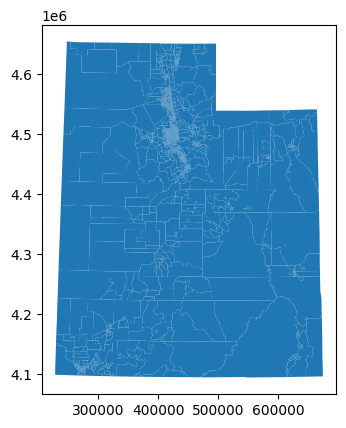

In [ ]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()